# 1st Method — Dissonance Threshold

In [13]:
%pip install --upgrade mido numpy pandas matplotlib enlighten scikit-learn seaborn

import mido
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import enlighten
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pathlib import Path

# Load metadata
df = pd.read_csv("maestro-v3.0.0/maestro-v3.0.0.csv")

# Add metadata column for absolute file paths
df["midi_path"] = df["midi_filename"].apply(
    lambda p: Path("maestro-v3.0.0") / p
)

# Split data; validation data possibly unnecessary
df_train = df[df["split"].isin(["train", "validation"])].head(160) # 962 + 137 elements
df_test  = df[df["split"] == "test"].head(40) # 177 elements

FPS = 20 # MIDI sampling/interpolation rate
ACTIVE_THRESHOLD = 64 # Threshold at which pedal is considered on
INTERVAL_DISSONANCE = { # Lookup for dissonance based on interval dissonance
    0: 0,   1: 4,  2: 4,
    3: 2,   4: 2,  5: 3,
    6: 5,   7: 1,
    8: 2,   9: 2,
    10: 4, 11: 4,
    12: 0
}

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\aobri\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [14]:
def interval_dissonance(n1, n2):
    interval = abs(n1 - n2) % 12
    return INTERVAL_DISSONANCE.get(interval, 0)

#####--------------------#####

def current_dissonance(notes):
    """Sum dissonances for all unique unordered pairs of notes."""
    if len(notes) < 2:
        return 0
    notes = list(notes)
    d = 0
    for i in range(len(notes)):
        for j in range(i + 1, len(notes)):
            d += interval_dissonance(notes[i], notes[j])
    return d

#####--------------------#####

def extract_pedal(midi):
    curve = []
    time_s = 0

    for msg in midi:
        time_s += msg.time
        # control=64 indicates sustain pedal
        if msg.type == "control_change" and msg.control == 64:
            # Append current time and pedal value
            curve.append((time_s, msg.value))
    return curve

#####--------------------#####

def pedal_to_binary(values, active_threshold=ACTIVE_THRESHOLD):
    values = np.asarray(values)
    return (values > active_threshold).astype(int)

#####--------------------#####

def resample_curve(times, values, fps=FPS):
    """
    Given irregular event times/values (like pedal or dissonance),
    resample to a regular FPS grid using forward-fill interpolation.
    """
    times = np.asarray(times)
    values = np.asarray(values)

    t_end = times[-1]
    t_grid = np.arange(0, t_end, 1.0 / fps)

    # For each grid time, find the last event time <= t
    idx = np.searchsorted(times, t_grid, side="right") - 1
    idx[idx < 0] = 0

    return t_grid, values[idx]

#####--------------------#####

def compute_dissonance_with_pedal(midi, active_threshold=ACTIVE_THRESHOLD):
    """
    Computes instantaneous harmonic dissonance across the entire MIDI,
    accounting for sustain pedal behavior.

    sounding_notes = notes currently heard (finger-held + pedal-held)
    finger_held    = notes currently pressed by fingers

    Dissonance at each event = sum of interval dissonances between all sounding notes.
    """
    times = []
    diss_curve = []

    current_time = 0
    pedal_down = False

    sounding_notes = set()
    finger_held = set()

    for msg in midi:
        current_time += msg.time

        # --- PEDAL EVENTS ---
        if msg.type == "control_change" and msg.control == 64:
            was_down = pedal_down
            pedal_down = msg.value > active_threshold

            # Pedal lifted, keep only finger-held notes
            if was_down and not pedal_down:
                sounding_notes = set(finger_held)

        # --- NOTE ON ---
        if msg.type == "note_on" and msg.velocity > 0:
            finger_held.add(msg.note)
            sounding_notes.add(msg.note)

        # --- NOTE OFF ---
        if msg.type == "note_off" or (msg.type == "note_on" and msg.velocity == 0):
            if msg.note in finger_held:
                finger_held.remove(msg.note)

            # When pedal is up, note is no longer sounding
            if not pedal_down and msg.note in sounding_notes:
                sounding_notes.remove(msg.note)

        # --- Compute instantaneous dissonance ---
        diss = current_dissonance(sounding_notes)

        times.append(current_time)
        diss_curve.append(diss)

    return np.array(times), np.array(diss_curve)

#####--------------------#####

def cumulative_dissonance(midi_path, tau):
    """
    Pedal default: down.
    Accumulate dissonance over time.
    Release pedal momentarily when accumulation exceeds tau.
    Returns: t_grid, ped_pred (0/1), dissonance resampled, accum over time
    """
    midi = mido.MidiFile(midi_path)

    # Dissonance curve
    diss_times, diss_vals = compute_dissonance_with_pedal(midi)
    t_grid, diss_res = resample_curve(diss_times, diss_vals)

    ped_pred = np.ones_like(diss_res, dtype=int) # start pedal down
    accum = 0
    accum_vals = np.zeros_like(diss_res)

    for i, d in enumerate(diss_res):
        accum += d
        accum_vals[i] = accum
        if accum > tau:
            ped_pred[i] = 0  # release pedal for one frame
            accum = 0        # reset accumulation

    return t_grid, ped_pred, accum_vals

#####--------------------#####

def get_release_dissonances(midi_path):
    """
    Returns: all dissonance values where the performer released the pedal
    """
    midi = mido.MidiFile(midi_path)

    # Pedal curve (irregular)
    ped_times, ped_vals = zip(*extract_pedal(midi))
    ped_vals = np.array(ped_vals)
    ped_binary = pedal_to_binary(ped_vals)

    # Dissonance curve (irregular)
    diss_times, diss_vals = compute_dissonance_with_pedal(midi)

    # Resample both to same grid
    t_ped, ped_res = resample_curve(ped_times, ped_binary)
    t_diss, diss_res = resample_curve(diss_times, diss_vals)

    # Identify moments where pedal goes 1 -> 0
    release_indices = np.where((ped_res[:-1] == 1) & (ped_res[1:] == 0))[0]

    # Get dissonance values right at release frames
    return diss_res[release_indices]

#####--------------------#####

def evaluate_threshold(df_test, tau):
    y_true_all = []
    y_pred_all = []

    for _, row in df_test.iterrows():
        midi_path = row["midi_path"]
        original_pedal = extract_pedal(mido.MidiFile(midi_path))
        ped_times, ped_vals = zip(*original_pedal)
        ped_binary = pedal_to_binary(np.array(ped_vals))
        t_grid_true, p_true = resample_curve(ped_times, ped_binary)

        # Predicted pedal
        t_grid_pred, p_pred, _ = cumulative_dissonance(midi_path, tau=tau)

        # Make sure lengths match
        min_len = min(len(p_true), len(p_pred))
        y_true_all.extend(p_true[:min_len])
        y_pred_all.extend(p_pred[:min_len])

    cm = confusion_matrix(y_true_all, y_pred_all)
    return cm

In [15]:
all_release_diss = []

manager = enlighten.get_manager()
pbar = manager.counter(total=len(df_train), desc='Finding Pedal Threshold', unit='file')

for _, row in df_train.iterrows():
    vals = get_release_dissonances(row["midi_path"])
    all_release_diss.extend(vals)
    pbar.update()

all_release_diss = np.array(all_release_diss)
manager.stop()

tau = np.median(all_release_diss)
print("Learned pedal-release threshold T =", tau)

Learned pedal-release threshold T = 54.0


## Sampling

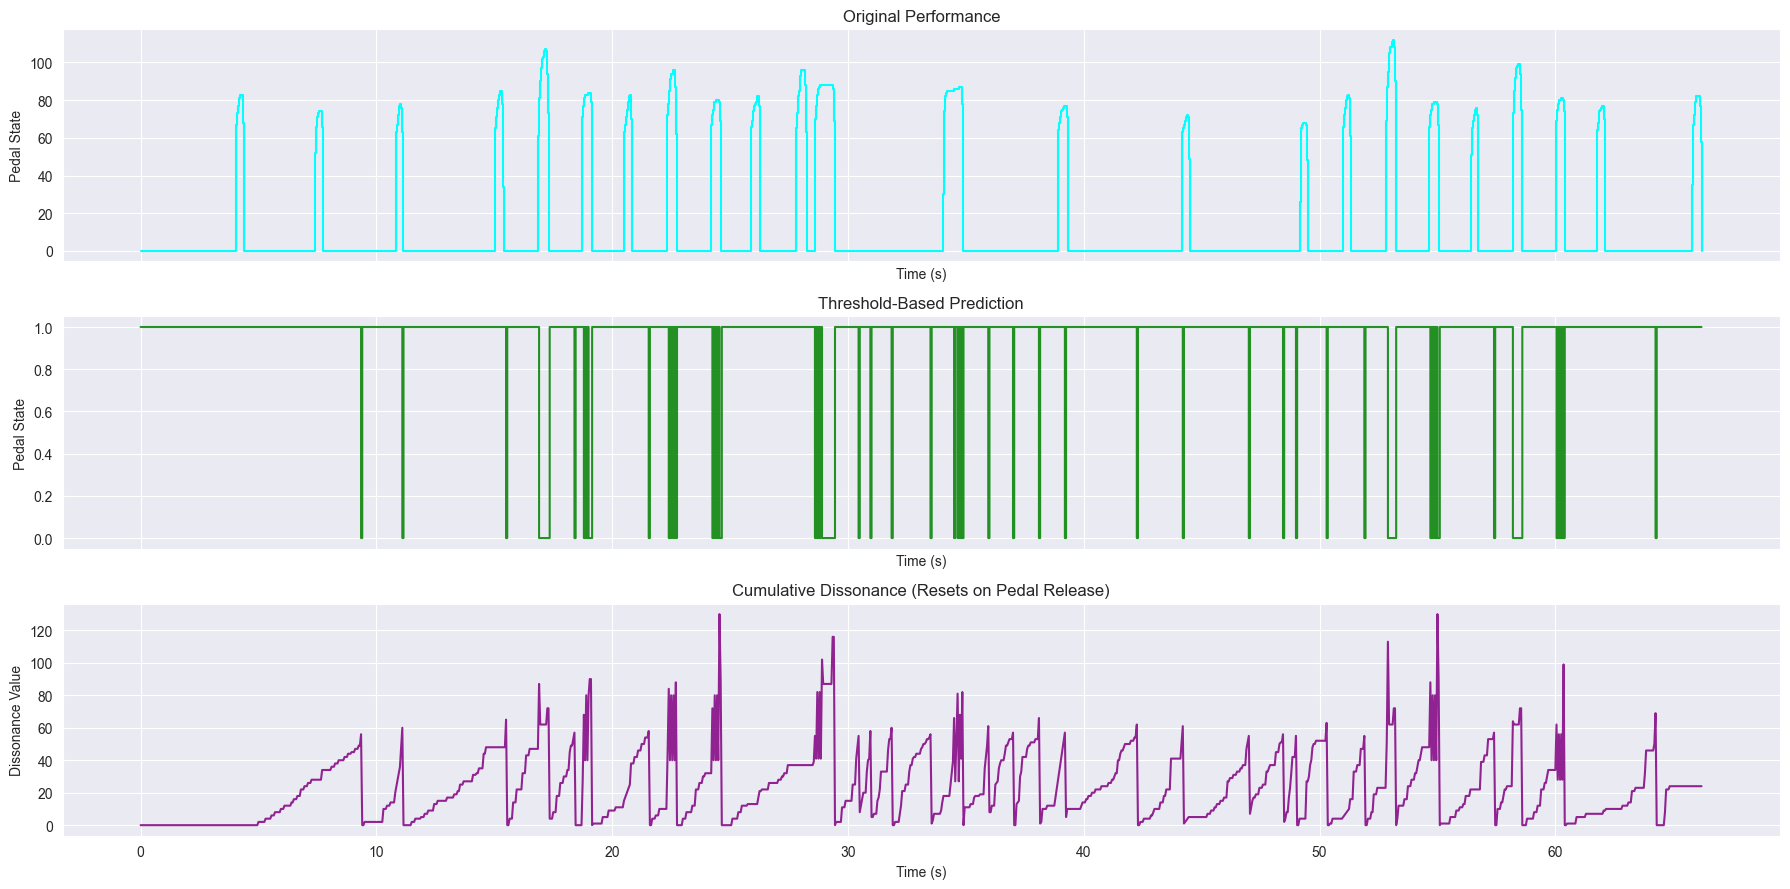

In [16]:
# https://www.youtube.com/watch?v=CaXhwrzS_0E
sample = df_test.iloc[14]["midi_path"]

# --- Extract curves ---
midi = mido.MidiFile(sample)

# Original pedal
ped_times, ped_values = zip(*extract_pedal(midi))
ped_values = np.array(ped_values)
ped_binary = pedal_to_binary(ped_values)

# Predicted pedal via cumulative dissonance
t_grid, ped_pred, accum_vals = cumulative_dissonance(sample, tau=tau)

# --- Plot ---
fig, axs = plt.subplots(3, 1, figsize=(18, 9), sharex=True)

axs[0].step(ped_times, ped_values, where='post', color='cyan')
axs[0].set_ylabel("Pedal State")
axs[0].set_xlabel("Time (s)")
axs[0].set_title("Original Performance")

axs[1].step(t_grid, ped_pred, where='post', color='green', alpha=0.85)
axs[1].set_ylabel("Pedal State")
axs[1].set_xlabel("Time (s)")
axs[1].set_title("Threshold-Based Prediction")

axs[2].plot(t_grid, accum_vals, color='purple', alpha=0.85)
axs[2].set_ylabel("Dissonance Value")
axs[2].set_xlabel("Time (s)")
axs[2].set_title("Cumulative Dissonance (Resets on Pedal Release)")

plt.tight_layout()
plt.show()

## Evaluation

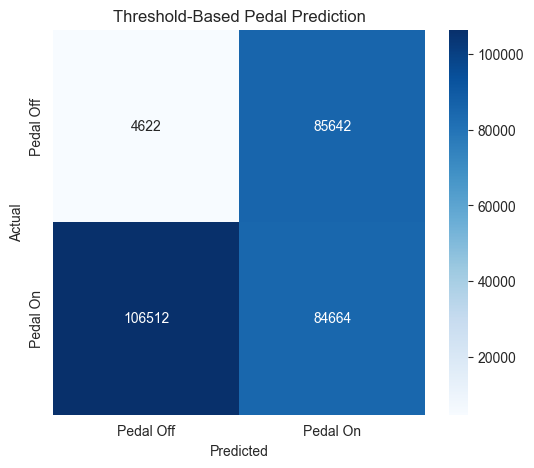

In [17]:
# Evaluate and plot
cm = evaluate_threshold(df_test, tau)

class_labels=["Pedal Off", "Pedal On"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Threshold-Based Pedal Prediction")
plt.show()